In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import csv
from datetime import datetime

/home/lucia/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [35]:
time = pd.read_csv('../important_data/twoM_newLabels.csv')
ids = pd.read_csv('../important_data/Id80PerRetained.csv')
time  = time[['text','id','negative_ny','userid','time','time_diff']]
time.shape

(4099, 6)

In [36]:
ids2 = ids[['userid']]
time = pd.merge(ids2, time, how = 'left', on = 'userid' )
time.shape

(4086, 6)

In [37]:
#select date
time['time'] = time['time'].apply(lambda x: x.split()[0])
time[1:5]

,userid,text,id,negative_ny,time,time_diff
1,009d96a823b6f6c085c092fb177491f6,"In honor of Mother's Day, we are trying to see...",948,4,05/05/2011,7
2,009d96a823b6f6c085c092fb177491f6,"What would your liqour do? If it could, it wou...",949,2,05/05/2011,7
3,009d96a823b6f6c085c092fb177491f6,War is about who's left not who's right.... be...,946,2,04/05/2011,8
4,009d96a823b6f6c085c092fb177491f6,Loving the fact my babie made me breakfast mmm...,942,2,01/05/2011,11


In [38]:
#convert to time series
# time['time'] = time['time'].apply(lambda x: parser.parse(x))
# time['time'] = time['time'].apply(lambda x: datetime.strptime(x, '%d %b %Y'))
time['time'] = time['time'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))
time['time'][1:10]

1   2011-05-05
2   2011-05-05
3   2011-05-04
4   2011-05-01
5   2011-04-28
6   2011-04-25
7   2011-04-20
8   2011-04-20
9   2011-04-19
Name: time, dtype: datetime64[ns]

In [39]:
#sort values according to userid, time and valence
time = time.sort_values(by=['userid','time_diff','negative_ny'],  ascending=False)
time[1:10]

,userid,text,id,negative_ny,time,time_diff
4083,fbd681e79ebca2cd9509218403f23ec6,Happy birthday Giancarlo!!!!!!!,4105,2,2010-12-20,57
4084,fbd681e79ebca2cd9509218403f23ec6,"I want a Christmas tree, I want a Christmas tr...",4106,2,2010-12-20,57
4082,fbd681e79ebca2cd9509218403f23ec6,SHOOTAH!,4107,2,2010-12-22,55
4081,fbd681e79ebca2cd9509218403f23ec6,"(oh, you're making me live) ... Oh, you're the...",276,2,2010-12-23,54
4080,fbd681e79ebca2cd9509218403f23ec6,?? ? /My ears like to talk,4110,4,2010-12-24,53
4079,fbd681e79ebca2cd9509218403f23ec6,DIVINE LITURGY THIS SUNDAY!!!!! YES YES YES YE...,4109,2,2010-12-24,53
4078,fbd681e79ebca2cd9509218403f23ec6,keeps stealing her little brother's presents...,4111,4,2010-12-25,52
4077,fbd681e79ebca2cd9509218403f23ec6,IT'S SNOWING!!!!!!! Finally!,4112,2,2010-12-26,51
4076,fbd681e79ebca2cd9509218403f23ec6,had a furious battle with a 6-foot snowdrift f...,4113,2,2010-12-27,50


In [40]:
#count_post = time.groupby(['userid']).size().reset_index(name='counts')
# #remove users with less than 10 post, they are acutally users who have 80% of their foreign language posts removed 
#clean = count_post.loc[count_post['counts'] >= 16, ]
#clean.shape

(74, 2)

Create user vector

In [52]:
def user_obj(dfUserid):
    users = {}
    for user in dfUserid:
       # print(user)
        if user not in users:
            users[user] = [-1]*60 
    return users

#get the which valence is dominate in one day
def getValenceFromMultipleDays(curdayPosts):
    positive_count = 0
    neg_count = 0
    neu_count = 0
    mix_count = 0
    for post in curdayPosts:
        if post == 1:
            neg_count += 1
        elif post == 3:
            mix_count += 1
        elif post == 4:
            neu_count += 1
        else:
            positive_count +=1
#     print(mix_count < positive_count or mix_count < neg_count)
#     print('neg_count{}, pos_count{}, neu_count{}, mix_count{}'. format(neg_count,positive_count,neu_count,mix_count))
    if (neg_count !=0 and (neg_count > positive_count or neg_count > neu_count or neg_count > mix_count )):
        return 1
    #give more weights to mix
    if (mix_count !=0 and (mix_count >= positive_count or mix_count >= neg_count or neg_count == positive_count)):
        return 3
    #here we give positive emotions more weights
    if (positive_count !=0 and (positive_count > neg_count or positive_count > neu_count or positive_count > mix_count)):
        return 2
    elif (neu_count !=0 and (neu_count >= positive_count or neu_count >= neg_count or neu_count > mix_count)):
        return 4
    else:
        return -1

def getValenceVector(userObject, df):
    preDay = None
    preValence = None
    curdayPosts = []
    for valence, day, user in zip(df['negative_ny'], df['time_diff'], df['userid']):

        posVal = 0
        if day == preDay:# and valence != preValence:
            curdayPosts.append(valence)

        else:
            dayvalence = getValenceFromMultipleDays(curdayPosts)
            curdayPosts = [valence]
            userObject[user][int(day)-1] = dayvalence
    return userObject


In [53]:
users = user_obj(time['userid'])
users2 = getValenceVector(users, time)

In [69]:
count = 0
emptyD = []
negativeD = []
positiveD = []
neutralD = []
mixed = []
for userid in users2:
    emptyD.append(users[userid].count(-1))
    negativeD.append(users[userid].count(1))
    positiveD.append(users[userid].count(2))
    neutralD.append(users[userid].count(4))
    mixed.append(users[userid].count(3))
    print('user {} has {} empty days, {} negative days, {} positive days {}, neutral days and mix days {}'.format(userid, users[userid].count(-1), users[userid].count(1), users[userid].count(2), users[userid].count(4), users[userid].count(3)))
    count += 1
count


user fbd681e79ebca2cd9509218403f23ec6 has 31 empty days, 7 negative days, 19 positive days 3, neutral days and mix days 0
user f8708568eff1535c85247b28dc126f9b has 1 empty days, 14 negative days, 38 positive days 6, neutral days and mix days 1
user f49956142aab2ad74decfd49a103c2f1 has 29 empty days, 9 negative days, 13 positive days 9, neutral days and mix days 0
user f358b75c71d85c91ec0452c6114e3b15 has 28 empty days, 7 negative days, 21 positive days 3, neutral days and mix days 1
user ec3dc451b8a811f05ace158a0d76e32e has 43 empty days, 10 negative days, 2 positive days 5, neutral days and mix days 0
user eaeabcfe25866f0455d349bae2450d88 has 27 empty days, 8 negative days, 20 positive days 5, neutral days and mix days 0
user e9970fe8848e9505b52d414d81611de8 has 40 empty days, 3 negative days, 11 positive days 5, neutral days and mix days 1
user e076953cd3fcf8927b8f21574c0890f3 has 27 empty days, 7 negative days, 15 positive days 10, neutral days and mix days 1
user dcbe08425f5edef5e5

74

statistics

In [77]:
df = pd.DataFrame(np.array(emptyD).reshape(74,1), columns=['EmptyDays'])
df['NegativeDays'] = negativeD
df['PositiveDays'] = positiveD
df['NeutralDays'] = neutralD
df['MixedDays'] = mixed
df[1:5]

,EmptyDays,NegativeDays,PositiveDays,NeutralDays,MixedDays
1,1,14,38,6,1
2,29,9,13,9,0
3,28,7,21,3,1
4,43,10,2,5,0


In [78]:
df.describe()

,EmptyDays,NegativeDays,PositiveDays,NeutralDays,MixedDays
count,74.000000,74.000000,74.000000,74.000000,74.000000
mean,28.364865,9.162162,16.243243,5.648649,0.581081
std,11.422849,5.627786,8.936321,3.624243,0.950944
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.250000,5.250000,11.000000,3.000000,0.000000
50%,30.000000,8.500000,15.000000,5.000000,0.000000
75%,37.000000,12.000000,19.750000,8.000000,1.000000
max,43.000000,39.000000,47.000000,14.000000,6.000000


Now we write the valence vector as csv file 

In [1069]:
#write result as csv
#header = ['userid','vector']
with open('../important_data/ValenceVec_Norm_Clean.csv','w') as csv_file:
    writer = csv.writer(csv_file)
   # writer.writerow(i for i in header)
    writer.writerow(users.keys())
    for row in zip(*users.values()):
        writer.writerow(list(row))

In [1070]:
valenceVec = pd.read_csv('../important_data/ValenceVec_Norm_Clean.csv')
valenceVec[1:5]

,fd3e8af4c8c61729334dae47c3cddd51,fbd681e79ebca2cd9509218403f23ec6,f8708568eff1535c85247b28dc126f9b,f49956142aab2ad74decfd49a103c2f1,f358b75c71d85c91ec0452c6114e3b15,ec3dc451b8a811f05ace158a0d76e32e,eaeabcfe25866f0455d349bae2450d88,e9970fe8848e9505b52d414d81611de8,e076953cd3fcf8927b8f21574c0890f3,dcbe08425f5edef5e5c1053f21e83640,...,1c1a61d11a10f9fa967f250095792db3,193165601dfad67e79ef52b2caf9fd9e,1789589a6d2bba0f09d768f8f3445be5,10aef9f9c929fbfcffa58b68eda20dfb,0e3fdb89c7706b13891170ab2a9017c7,0c5d06511ef79fba34da417e8c751fff,0b12516100c16f779b152858619786ff,088bf0ed841bcc366475b3975eb1b9d2,0724fe854bd455061ba84efecdeff469,009d96a823b6f6c085c092fb177491f6
1,-1,-1,2,-1,2,1,4,-1,2,-1,...,2,-1,2,-1,1,-1,1,2,-1,-1
2,-1,-1,2,-1,2,1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,1,-1,-1,-1
3,-1,-1,2,2,1,4,2,-1,2,2,...,-1,-1,-1,-1,2,-1,-1,-1,2,2
4,-1,-1,1,1,-1,2,1,-1,2,4,...,2,2,1,-1,1,-1,1,-1,-1,-1


In [1071]:
valenceVec = valenceVec.transpose()
valenceVec[1:5]


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
fbd681e79ebca2cd9509218403f23ec6,-1,-1,-1,-1,-1,1,2,2,2,2,...,4,2,4,2,2,-1,2,-1,2,-1
f8708568eff1535c85247b28dc126f9b,2,2,2,2,1,1,2,2,4,-1,...,1,2,2,2,1,2,2,4,1,2
f49956142aab2ad74decfd49a103c2f1,-1,-1,-1,2,1,4,2,2,-1,4,...,-1,-1,1,4,4,-1,1,1,4,-1
f358b75c71d85c91ec0452c6114e3b15,-1,2,2,1,-1,2,-1,2,-1,4,...,-1,2,2,2,-1,2,-1,-1,-1,-1


need to mannually change first column to userid

In [1072]:
valenceVec.to_csv('../important_data/ValenceVec_Norm_Clean2.csv')

In [1085]:
#merge with CESD
cesd = pd.read_csv('../important_data/adjustedCESD.csv')
cesdSum = cesd[['userid','cesd_sum']]
valenceVec = pd.read_csv('../important_data/ValenceVec_Norm_Mix.csv')
ValCesd = pd.merge(valenceVec, cesdSum, how = 'left', on ='userid')
#remove duplicate
ValCesd = ValCesd.drop_duplicates(subset='userid', keep="first")
ValCesd.shape


(77, 62)

In [292]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, f1_score, precision_score,\
recall_score, confusion_matrix, classification_report, accuracy_score 
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn import svm
from sklearn.model_selection import train_test_split


binary classifer, 23 as threadshold

In [1091]:
y = ValCesd["cesd_sum"]
X = ValCesd.iloc[:,1:31]
def recode(array):
    new = []
    for num in array:
        if num <= 23:
            new.append(0)
        if num > 23:
            new.append(1)
    return new
        
y = recode(y)
print(y.count(1))
print(y.count(0))

41
36


Don't scale it, all the features are on the same scale already

In [1094]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 70)
cv = StratifiedKFold(n_splits=3, random_state = 0)
svc = make_pipeline(svm.SVC())
parameters = [{'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'svc__gamma': [0.5,0.1, 0.01,0.001, 0.0001],
                     'svc__C':[0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.5, 2.0, 10] , 'svc__class_weight':['balanced']}]

grid_search_item = GridSearchCV(svc,
                          param_grid = parameters,
                           cv = cv,
                           scoring = 'accuracy',
                           n_jobs = -1)
grid_searchSVC = grid_search_item.fit(X_train, y_train)

print(grid_searchSVC.best_score_)
print(grid_searchSVC.best_params_)

means = grid_searchSVC.cv_results_['mean_test_score']
stds = grid_searchSVC.cv_results_['std_test_score']
params = grid_searchSVC.cv_results_['params']

y_true, y_pred = y_test, grid_searchSVC.predict(X_test)
print(classification_report(y_true, y_pred))

0.6792452830188679
{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.5, 'svc__kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.47      0.70      0.56        10
           1       0.67      0.43      0.52        14

   micro avg       0.54      0.54      0.54        24
   macro avg       0.57      0.56      0.54        24
weighted avg       0.58      0.54      0.54        24



/Users/lucia/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [1095]:
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
Ada = AdaBoostClassifier()
parameters = [{'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [50,100,150,200],
                     'learning_rate':[1.0, 1.5, 2.0, 2.5, 3.0],'random_state':[100]}]

grid_search_item = GridSearchCV(Ada,
                          param_grid = parameters,
                           cv = cv,
                           scoring = 'accuracy',
                           n_jobs = -1)
grid_search = grid_search_item.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))


0.6415094339622641
{'algorithm': 'SAMME', 'learning_rate': 1.5, 'n_estimators': 100, 'random_state': 100}
              precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.88      0.50      0.64        14

   micro avg       0.67      0.67      0.67        24
   macro avg       0.72      0.70      0.66        24
weighted avg       0.74      0.67      0.66        24



/Users/lucia/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [1033]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
parameters = [{'max_depth': [1,2,3,4,5], 'n_estimators': [50,100,150,200],
                     'learning_rate':[1.0, 1.5, 2.0, 2.5, 3.0],'random_state':[100]}]
grid_search_item = GridSearchCV(gbc,
                          param_grid = parameters,
                           cv = cv,
                           scoring = 'accuracy',
                           n_jobs = -1)
grid_search = grid_search_item.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

0.6037735849056604
{'learning_rate': 1.0, 'max_depth': 4, 'n_estimators': 50, 'random_state': 100}
              precision    recall  f1-score   support

           0       0.38      0.56      0.45         9
           1       0.64      0.47      0.54        15

   micro avg       0.50      0.50      0.50        24
   macro avg       0.51      0.51      0.50        24
weighted avg       0.54      0.50      0.51        24



/Users/lucia/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [645]:
gnb.get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [1096]:
from sklearn.linear_model import SGDClassifier
clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter= 1000, random_state = 2))
parameters = [{'sgdclassifier__alpha': [0.001, 0.01, 0.05, 0.001, 0.005], 'sgdclassifier__class_weight':['balanced'],
              'sgdclassifier__loss': ['hinge','log','modified_huber','squared_hinge', 'perceptron'], 
               'sgdclassifier__penalty':['none','l1','l2']}]
grid_search_item = GridSearchCV(clf,
                          param_grid = parameters,
                           cv = cv,
                           scoring = 'accuracy',
                           n_jobs = -1)
grid_search = grid_search_item.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

0.6415094339622641
{'sgdclassifier__alpha': 0.01, 'sgdclassifier__class_weight': 'balanced', 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'none'}
              precision    recall  f1-score   support

           0       0.47      0.70      0.56        10
           1       0.67      0.43      0.52        14

   micro avg       0.54      0.54      0.54        24
   macro avg       0.57      0.56      0.54        24
weighted avg       0.58      0.54      0.54        24



/Users/lucia/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/lucia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/lucia/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/lucia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for 

In [1053]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

estimators = []

model3 = svm.SVC(C = 2.0, kernel  = 'sigmoid', gamma =0.01,class_weight = 'balanced', random_state=300)
estimators.append(('svm', model3))
model2 = SGDClassifier(alpha = 0.001, class_weight = 'balanced', loss = 'hinge', penalty = 'l2', random_state = 2)
estimators.append(('logistic', model2))
model1 = GradientBoostingClassifier(max_depth= 4, learning_rate= 1.0, n_estimators= 50, random_state= 100)
estimators.append(('gbc', model1))
# model4 = AdaBoostClassifier(algorithm= 'SAMME', learning_rate= 2.0, n_estimators= 50, random_state= 100)
# estimators.append(('ada', model4))

ensemble = VotingClassifier(estimators)
eclf1 = ensemble.fit(X_train, y_train)
y_pred = eclf1.predict(X_test)
print('ROC is {}'. format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)


ROC is 0.6000000000000001
              precision    recall  f1-score   support

           0       0.46      0.67      0.55         9
           1       0.73      0.53      0.62        15

   micro avg       0.58      0.58      0.58        24
   macro avg       0.59      0.60      0.58        24
weighted avg       0.63      0.58      0.59        24



/Users/lucia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([[6, 3],
       [7, 8]])

Ensemble classfier won't work because the classifers in our case does not produce results that compensate each other, so we can adopt svm only

ROC AUC score
A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

[0.         0.33333333 1.        ] [0.         0.73333333 1.        ] [2 1 0]


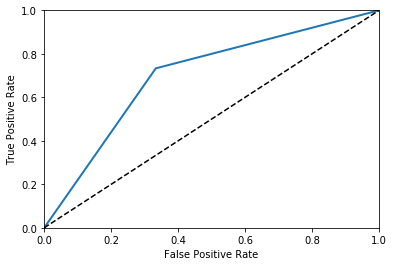

In [1042]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
print(fpr, tpr, thresholds)
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr) 
plt.show()

In [674]:
print(y_true)

[0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1]


In [675]:
print(y_pred)

[1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1]


In [1077]:
#select cases in the test set
indexes = X_test.index.values
TestVal = ValCesd.loc[indexes]

In [1078]:
TestVal[1:5]

,userid,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,cesd_sum
90,0e3fdb89c7706b13891170ab2a9017c7,2,1,-1,2,1,1,2,-1,-1,...,2,2,4,-1,-1,-1,-1,-1,-1,4
79,23cbbe03a89344129e1a6d8419a66d23,-1,-1,-1,-1,-1,-1,1,-1,1,...,4,2,-1,2,2,2,2,2,2,28
12,e9970fe8848e9505b52d414d81611de8,2,-1,-1,-1,-1,4,-1,-1,4,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,34
65,4764518d32334248e6ebbf681a18fd0c,4,4,-1,2,2,4,1,1,-1,...,4,2,1,2,4,-1,-1,1,1,23


In [1079]:
TestVal['labels'] = y_test
TestVal['prelabels'] = y_pred

[0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1]

In [170]:
TestVal[1:5]
TestVal.to_csv('preEvaluate.csv')

Let's see what features the classifer capture`

In [1045]:
#juding from the confusion matix (class 0, class 1), most of the class 0 are predicted correctly
confusion_matrix(y_test, y_pred)

array([[ 6,  3],
       [ 4, 11]])

In [1046]:
#let's see the features of class 1 (high depression symptoms)
from collections import Counter
def DescribeUserVecTestSet(labelClass):
    highDep = []
    for userid, labels, prelabels in zip(TestVal['userid'],TestVal['labels'],TestVal['prelabels']):
    #     print(userid, labels, prelabels)
        if prelabels == labelClass:
            highDep.append(userid)

    for userid in highDep:
        print('user {} has {} empty days, {} negative days, {} positive days and {} neutral days'.format(userid, users[userid].count(-1), users[userid].count(1), users[userid].count(2), users[userid].count(4)))
    
    print('--------here shows the stats for label class-----------------')
    describeUserVec(highDep)
#Here we see the prediction labels: high group vectors
DescribeUserVecTestSet(1)

user b6f1257ff213585723c66e253d2b92f7 has 42 empty days, 6 negative days, 6 positive days and 6 neutral days
user 0e3fdb89c7706b13891170ab2a9017c7 has 32 empty days, 4 negative days, 20 positive days and 4 neutral days
user 23cbbe03a89344129e1a6d8419a66d23 has 33 empty days, 3 negative days, 20 positive days and 3 neutral days
user cd86d1e6d68c3770eaec0db419dceb2f has 15 empty days, 18 negative days, 16 positive days and 10 neutral days
user 0724fe854bd455061ba84efecdeff469 has 36 empty days, 11 negative days, 11 positive days and 2 neutral days
user 83b42f70e17daecbc41b785c2b9ce869 has 36 empty days, 5 negative days, 15 positive days and 4 neutral days
user 5fcf46eb6809a240af3ab9bcb4f2b92f has 33 empty days, 10 negative days, 8 positive days and 9 neutral days
user 5b1eb32579450829ec8faab4d3472ffb has 38 empty days, 4 negative days, 10 positive days and 5 neutral days
user 1789589a6d2bba0f09d768f8f3445be5 has 30 empty days, 13 negative days, 10 positive days and 6 neutral days
user 0b

In [1047]:
#low group vectors
DescribeUserVecTestSet(0)

user e9970fe8848e9505b52d414d81611de8 has 40 empty days, 3 negative days, 11 positive days and 5 neutral days
user 4764518d32334248e6ebbf681a18fd0c has 12 empty days, 15 negative days, 20 positive days and 12 neutral days
user 193165601dfad67e79ef52b2caf9fd9e has 43 empty days, 6 negative days, 9 positive days and 1 neutral days
user b121d90e407cd597da17491f36e7b2c5 has 42 empty days, 7 negative days, 8 positive days and 2 neutral days
user 49fb9fce8f4dc022318b8cd432aad8b6 has 35 empty days, 7 negative days, 18 positive days and 0 neutral days
user cfb021cfbff46ffdb75c7dcafe7c2087 has 23 empty days, 11 negative days, 13 positive days and 12 neutral days
user 3e61391d06340a430182ec676ed47eaf has 53 empty days, 1 negative days, 1 positive days and 5 neutral days
user 66495ec54feb9e2399db05a67a80f2c6 has 37 empty days, 3 negative days, 19 positive days and 0 neutral days
user 0c5d06511ef79fba34da417e8c751fff has 38 empty days, 8 negative days, 12 positive days and 2 neutral days
user d538

We can see the classifier predict those with less empty days, more positive days and more neutral days as high group


Let's see what are the actual difference between low and high group

In [1048]:
TestVal['labels'] = y_test
def DescribeUserVecTestSet(labelClass):
    highDep = []
    for userid, labels, prelabels in zip(TestVal['userid'],TestVal['labels'],TestVal['prelabels']):
    #     print(userid, labels, prelabels)
        if labels == labelClass:
            highDep.append(userid)

    for userid in highDep:
        print('user {} has {} empty days, {} negative days, {} positive days and {} neutral days'.format(userid, users[userid].count(-1), users[userid].count(1), users[userid].count(2), users[userid].count(4)))
    
    print('--------here shows the stats for label class-----------------')
    describeUserVec(highDep)
#Here we see the prediction labels: high group vectors

In [1049]:
#high group
DescribeUserVecTestSet(1)

user 23cbbe03a89344129e1a6d8419a66d23 has 33 empty days, 3 negative days, 20 positive days and 3 neutral days
user e9970fe8848e9505b52d414d81611de8 has 40 empty days, 3 negative days, 11 positive days and 5 neutral days
user cd86d1e6d68c3770eaec0db419dceb2f has 15 empty days, 18 negative days, 16 positive days and 10 neutral days
user 83b42f70e17daecbc41b785c2b9ce869 has 36 empty days, 5 negative days, 15 positive days and 4 neutral days
user 5fcf46eb6809a240af3ab9bcb4f2b92f has 33 empty days, 10 negative days, 8 positive days and 9 neutral days
user 49fb9fce8f4dc022318b8cd432aad8b6 has 35 empty days, 7 negative days, 18 positive days and 0 neutral days
user 5b1eb32579450829ec8faab4d3472ffb has 38 empty days, 4 negative days, 10 positive days and 5 neutral days
user cfb021cfbff46ffdb75c7dcafe7c2087 has 23 empty days, 11 negative days, 13 positive days and 12 neutral days
user 1789589a6d2bba0f09d768f8f3445be5 has 30 empty days, 13 negative days, 10 positive days and 6 neutral days
user 

In [1050]:
#low group
DescribeUserVecTestSet(0)

user b6f1257ff213585723c66e253d2b92f7 has 42 empty days, 6 negative days, 6 positive days and 6 neutral days
user 0e3fdb89c7706b13891170ab2a9017c7 has 32 empty days, 4 negative days, 20 positive days and 4 neutral days
user 4764518d32334248e6ebbf681a18fd0c has 12 empty days, 15 negative days, 20 positive days and 12 neutral days
user 0724fe854bd455061ba84efecdeff469 has 36 empty days, 11 negative days, 11 positive days and 2 neutral days
user 193165601dfad67e79ef52b2caf9fd9e has 43 empty days, 6 negative days, 9 positive days and 1 neutral days
user b121d90e407cd597da17491f36e7b2c5 has 42 empty days, 7 negative days, 8 positive days and 2 neutral days
user 3e61391d06340a430182ec676ed47eaf has 53 empty days, 1 negative days, 1 positive days and 5 neutral days
user 66495ec54feb9e2399db05a67a80f2c6 has 37 empty days, 3 negative days, 19 positive days and 0 neutral days
user d5380466e18422d7b2c2d54d57cbbde2 has 36 empty days, 9 negative days, 9 positive days and 5 neutral days
--------here

In the test set, we can see that people in the high group are indeed have more positive days and less empty days in general, the classifer capture the right information

In [1081]:
ValCesd['biLabel'] = y

In [1082]:
ValCesd.describe()

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,cesd_sum,biLabel
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,...,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.610390,0.727273,0.545455,0.545455,0.636364,0.714286,0.792208,0.610390,0.636364,0.922078,...,0.597403,0.467532,0.636364,0.844156,0.493506,0.363636,0.298701,0.324675,23.857143,0.532468
std,1.800262,1.789122,1.788453,1.577352,1.653617,1.746102,1.757223,1.639607,1.776373,1.752939,...,1.726418,1.788740,1.653617,1.694146,1.698477,1.555204,1.504947,1.584809,11.758216,0.502217
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.000000,0.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,15.000000,0.000000
50%,-1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,25.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,33.000000,1.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,48.000000,1.000000
